# HEART DISEASE DETECTION

**GOAL** : To predict whether a person has heart disease or not.

**OUTCOME:**

I built two models(linear regression and random forest). The linear regression model performed better with the following metrics:

    * Accuracy - 0.773
    
    *roc_auc - 0.874
    
    


# Introduction

This datset contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presecnce of heart disease in the patient.

**Content**

Attribute information :

1. Age 

2. Sex

3. chest pain type (4 values)

4. resting blood pressure

5. serum cholestoral in mg/dg

6. fasting blood sugar > 120mg/dl

7. resting electrocardiographic results (vaLUES 0,1,2)

8. maximum heart rate achieved

9. exercise induced angina

10. oldpeak = ST depression induced by exercise relative to test

11. the slope of the peak exercise ST segment

12. number of major vessels (0-3) colored by flourosopy

13. thal: 3 = normal ; 6 = fixed defect; 7 = reversable defect

**PLAN**

1. Clean the data

2. Visuaize the data

3. Build a prediction model(random forest and linear regression)

4. Evaluate the model.


**Load in the dataset**

In [1]:
heart <- read.csv("../input/heart-disease-uci/heart.csv",stringsAsFactors = FALSE)

**Load in the libraries**

In [2]:
library(tidyverse)
library(tidymodels)
library(corrplot)
library(ggcorrplot)
library(vip)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.2      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.8 
✔ infer     0.5.3      ✔ tune      0.1.2 
✔ modeldata 0.1.0      ✔ workflows 0.2.1 
✔ parsnip   0.1.4      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::

A quick look at the dataset.

In [3]:
str(heart)

'data.frame':	303 obs. of  14 variables:
 $ age     : int  63 37 41 56 57 57 56 44 52 57 ...
 $ sex     : int  1 1 0 1 0 1 0 1 1 1 ...
 $ cp      : int  3 2 1 1 0 0 1 1 2 2 ...
 $ trestbps: int  145 130 130 120 120 140 140 120 172 150 ...
 $ chol    : int  233 250 204 236 354 192 294 263 199 168 ...
 $ fbs     : int  1 0 0 0 0 0 0 0 1 0 ...
 $ restecg : int  0 1 0 1 1 1 0 1 1 1 ...
 $ thalach : int  150 187 172 178 163 148 153 173 162 174 ...
 $ exang   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ oldpeak : num  2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...
 $ slope   : int  0 0 2 2 2 1 1 2 2 2 ...
 $ ca      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ thal    : int  1 2 2 2 2 1 2 3 3 2 ...
 $ target  : int  1 1 1 1 1 1 1 1 1 1 ...


# DATA CLEANING

I will check for missing values.

In [4]:
Missing_Indices <- sapply(heart, function(x)sum(is.na(x)))
Missing_Values <- data.frame(Name=names(heart), Indices=Missing_Indices)
Missing_Values[Missing_Values$Indices>0,]

Name,Indices
<fct>,<int>


There are no missing values.

Most values in the data are either o or 1. 1 for positive response and o for negative response. We will rename them.

In [5]:
heart_clean <- heart %>% 
  mutate(target = ifelse(target == 1 , "Yes", "No"),
         sex = ifelse(sex == 1 , "Male", "Female"),
         fbs = ifelse(fbs == 1 , ">125", "<125"),
         exang = ifelse(exang == 1 , "Yes", "No"),
         cp = case_when(cp == 1 ~ "ATYPICAL ANGINA",
                        cp == 2 ~ "NON-ANGINAL PAIN",
                        cp == 3 ~ "ASYMPTOMATIC",
                        cp == 0 ~ "None"),
         restecg = ifelse(restecg == 0, "NORMAL", "ABMORMALITY"),
         slope = as.factor(slope),
         ca = as.factor(ca)) %>% 
 mutate_if(is.character, as.factor)

colnames(heart_clean)[1] <- "age"

# EDA

**What percantage of people have a heart disease?**

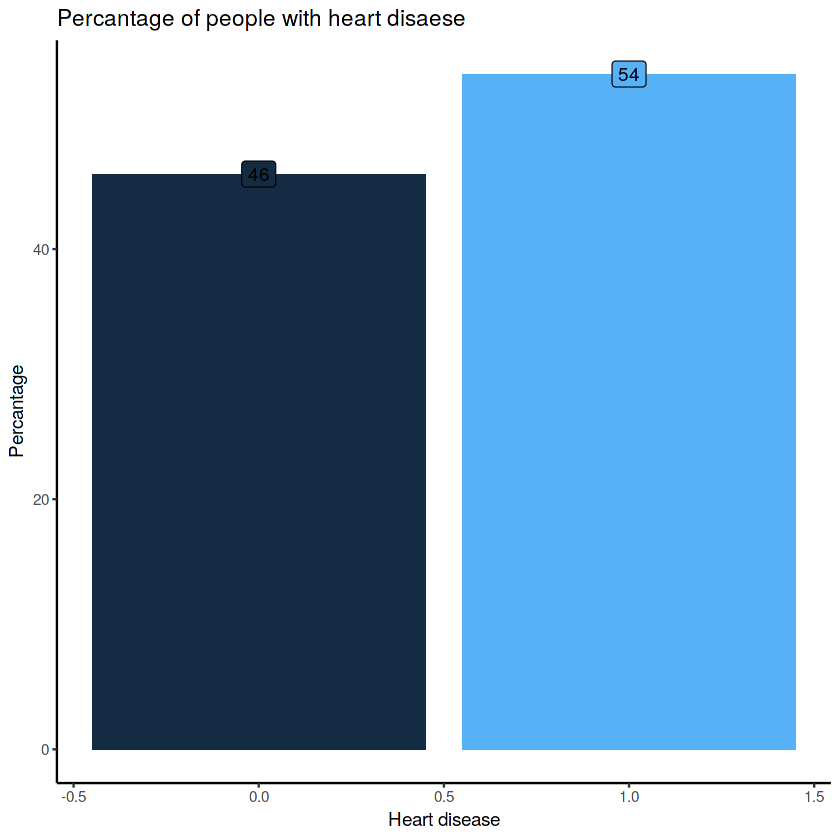

In [6]:
heart %>% 
  count(target) %>% 
  mutate(pct =round( n / sum(n) * 100),2) %>% 
  ggplot(aes(target, pct, fill = target)) +
  geom_col( show.legend = FALSE) +
  geom_label(aes(label = pct)) +
  theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Percantage of people with heart disaese",
       y = "Percantage",
       x = "Heart disease")

** What is the distribution of heart disease across age?**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



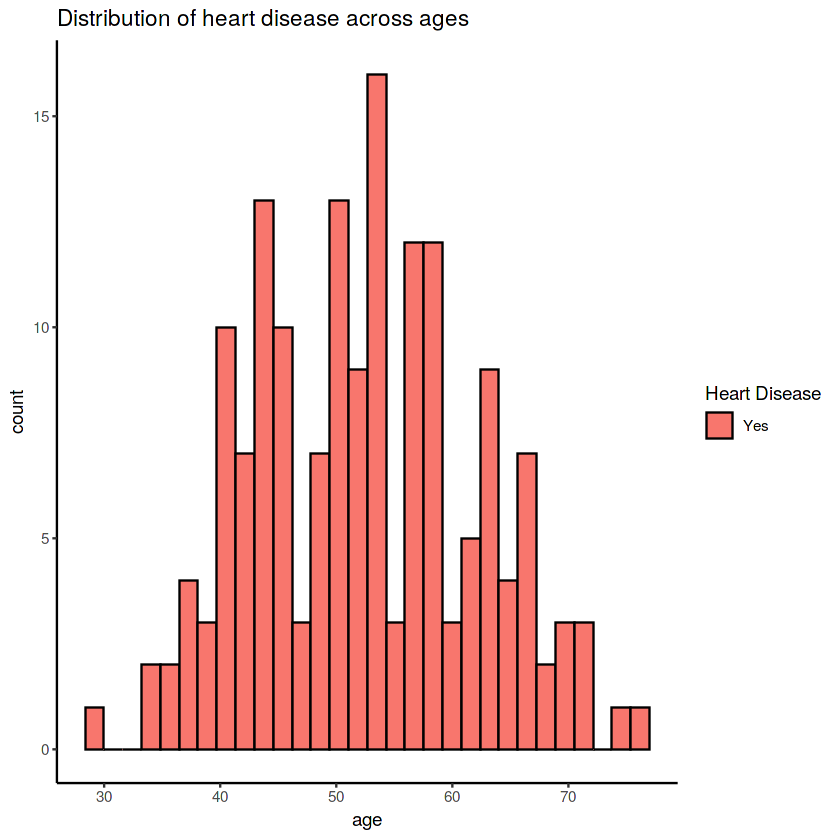

In [7]:
heart_clean %>% 
  filter(target == "Yes") %>% 
  ggplot(aes(age, fill = target)) +
  geom_histogram(color = "black") +
  theme_classic() +
  guides(fill = guide_legend(title = "Heart Disease")) +
  ggtitle("Distribution of heart disease across ages")

It is more common btwn 40-60 years.

** What is the distribution of age across gender?**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



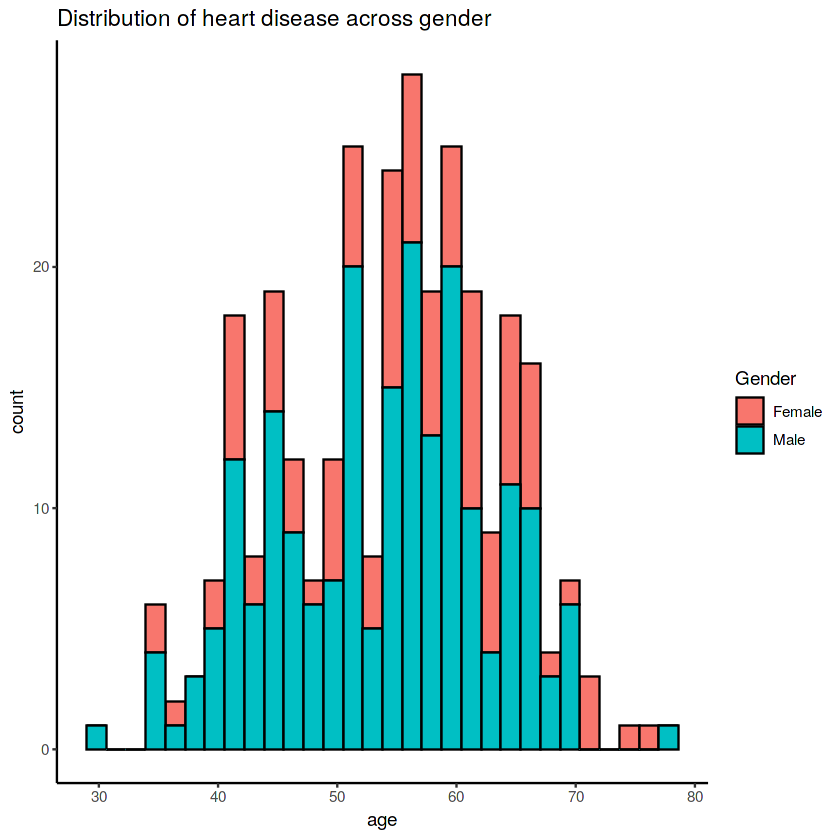

In [8]:
heart_clean %>% 
  ggplot(aes(age, fill = sex)) +
  geom_histogram(color = "black") +
  theme_classic() +
  guides(fill = guide_legend(title = "Gender")) +
  ggtitle("Distribution of heart disease across gender")

Males are the majority suffering from heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



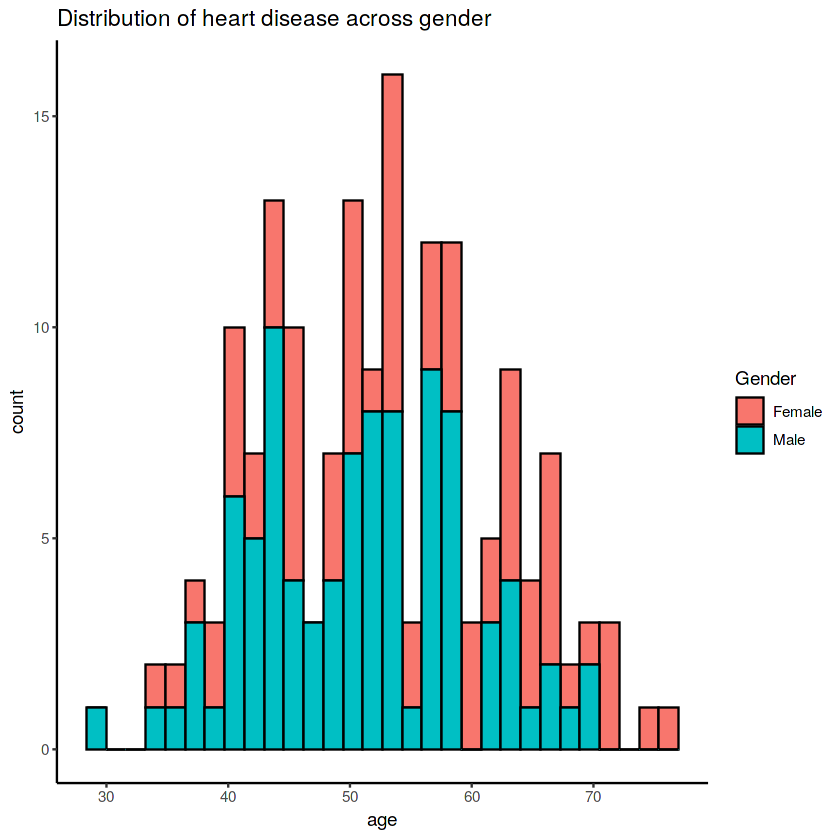

In [9]:
heart_clean %>% 
  filter(target == "Yes") %>% 
  ggplot(aes(age, fill = sex)) +
  geom_histogram(color = "black") +
  theme_classic() +
  guides(fill = guide_legend(title = "Gender")) +
  ggtitle("Distribution of heart disease across gender")

**What is the count of gender with heart disease?**

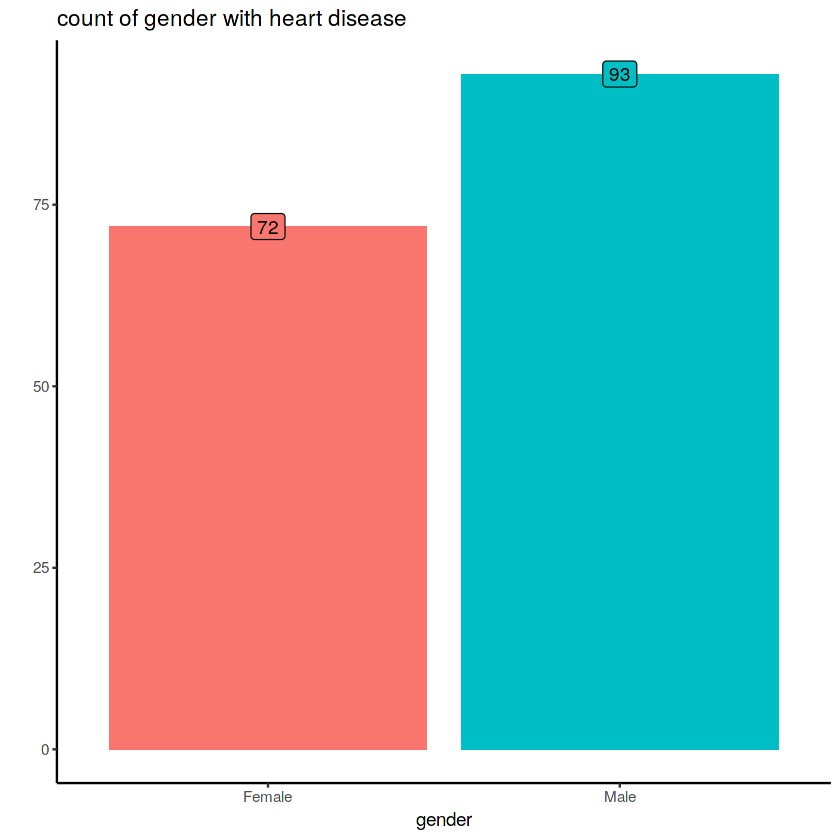

In [10]:
heart_clean %>% 
  filter(target == "Yes") %>% 
  count(sex) %>% 
  ggplot(aes(sex, n, fill = sex)) +
  geom_col(show.legend = F) + 
  theme_classic() +
  geom_label(aes(label = n)) +
  theme(legend.position = "none") +
  labs(title = "count of gender with heart disease",
       y = "",
       x = "gender")

**Levels of cholosterol in the genders across the ages**

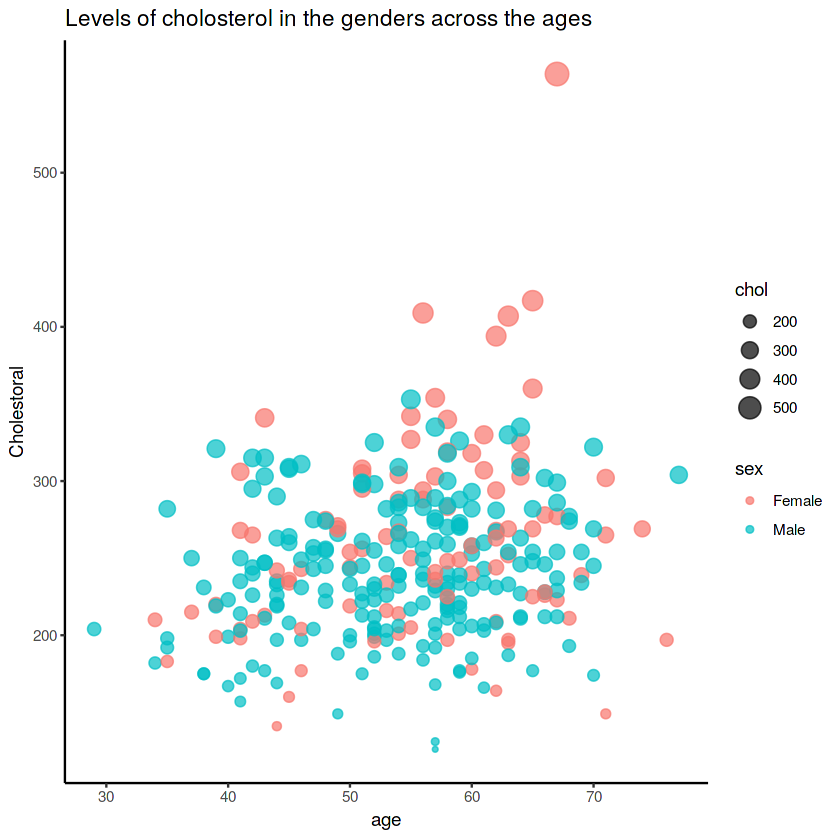

In [11]:
heart_clean %>% 
  ggplot(aes(age, chol, col = sex , size = chol )) +
  geom_point(alpha = 0.7) +
  theme_classic() +
  labs(title = "Levels of cholosterol in the genders across the ages",
       y = "Cholestoral") +
  guides(fill = guide_legend(title ="Gender"))

**Levels of resting blood pressure in the genders across the ages**

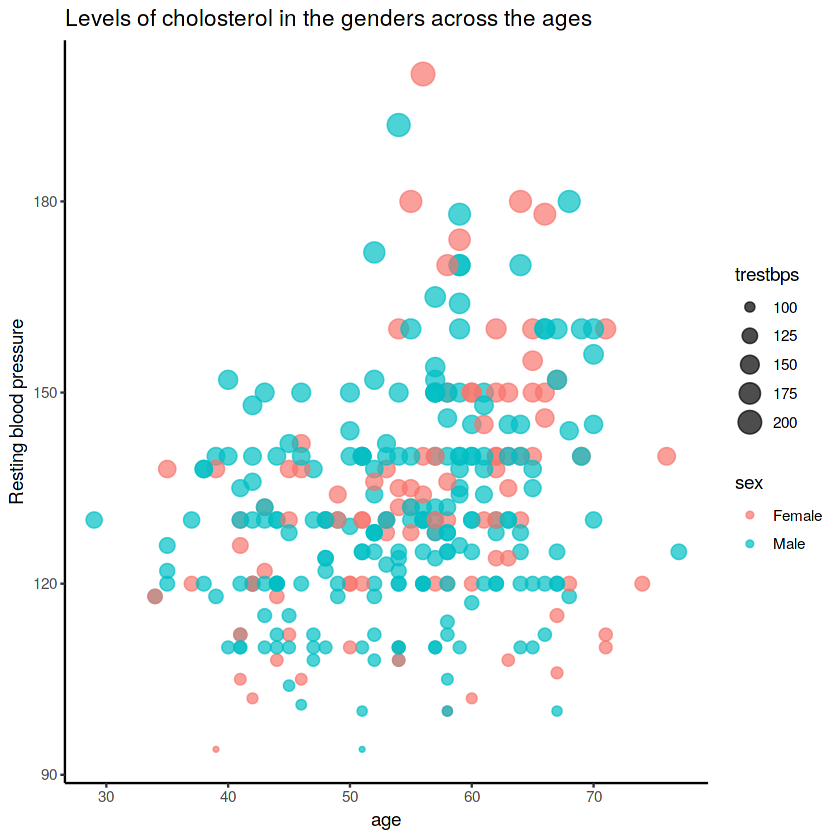

In [12]:
heart_clean %>% 
  ggplot(aes(age, trestbps, col = sex , size = trestbps )) +
  geom_point(alpha = 0.7) +
  theme_classic() +
  labs(title = "Levels of cholosterol in the genders across the ages",
       y = "Resting blood pressure") +
  guides(fill = guide_legend(title ="Gender"))

**Levels of maximum heart rate achieved in the genders across the ages**

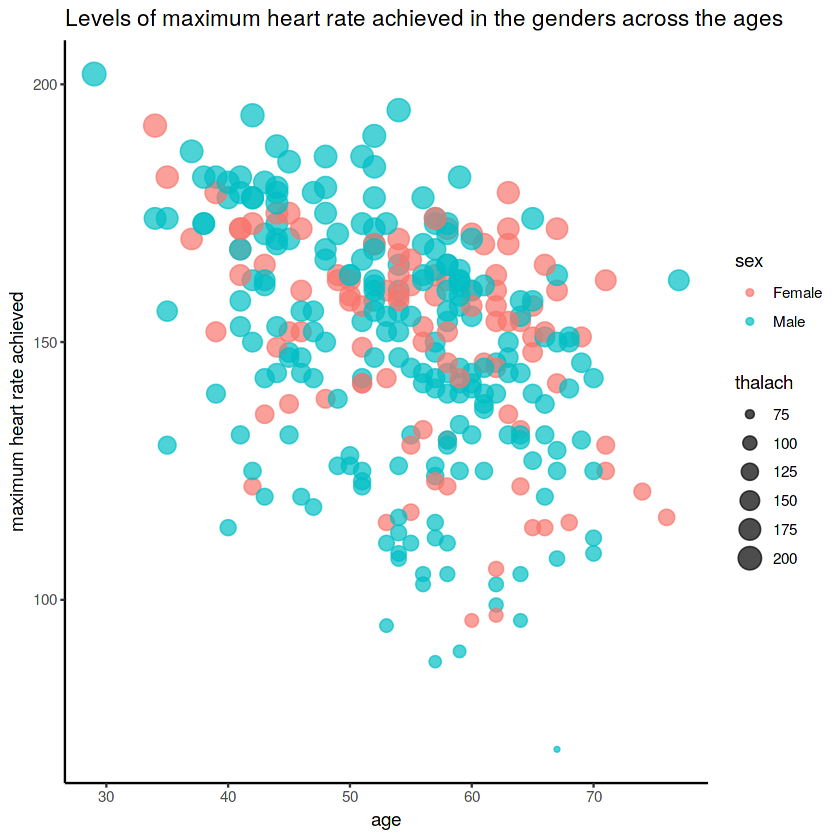

In [13]:
heart_clean %>% 
  ggplot(aes(age, thalach, col = sex , size = thalach )) +
  geom_point(alpha = 0.7) +
  theme_classic() +
  labs(title = "Levels of maximum heart rate achieved in the genders across the ages",
       y = "maximum heart rate achieved") +
  guides(fill = guide_legend(title ="Gender"))

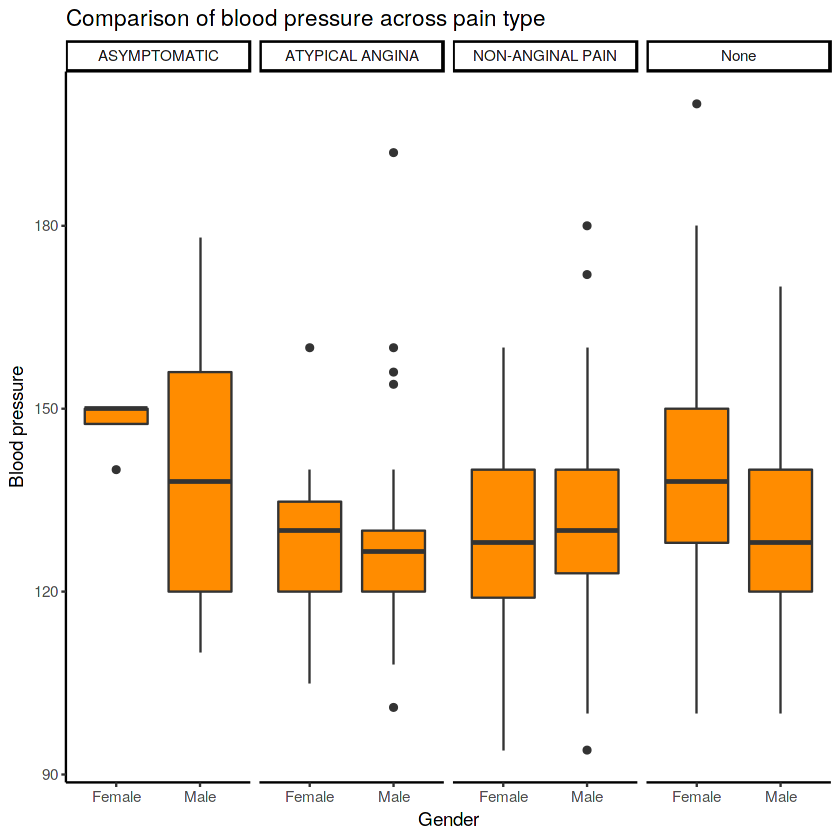

In [14]:
heart_clean %>% 
  ggplot(aes(sex, trestbps )) +
  geom_boxplot(fill = "darkorange") +
  theme_classic() +
  labs(title = "Comparison of blood pressure across pain type",
       y = "Blood pressure",
       x = "Gender") +
 facet_grid(~cp)

Blood pressure is highest in the "Asymptomatic" chest pain and lowest in the "Atypical angina".

Females tend to generally have a higher blood pressure compared to males.

**comparison of Pain types across ages**

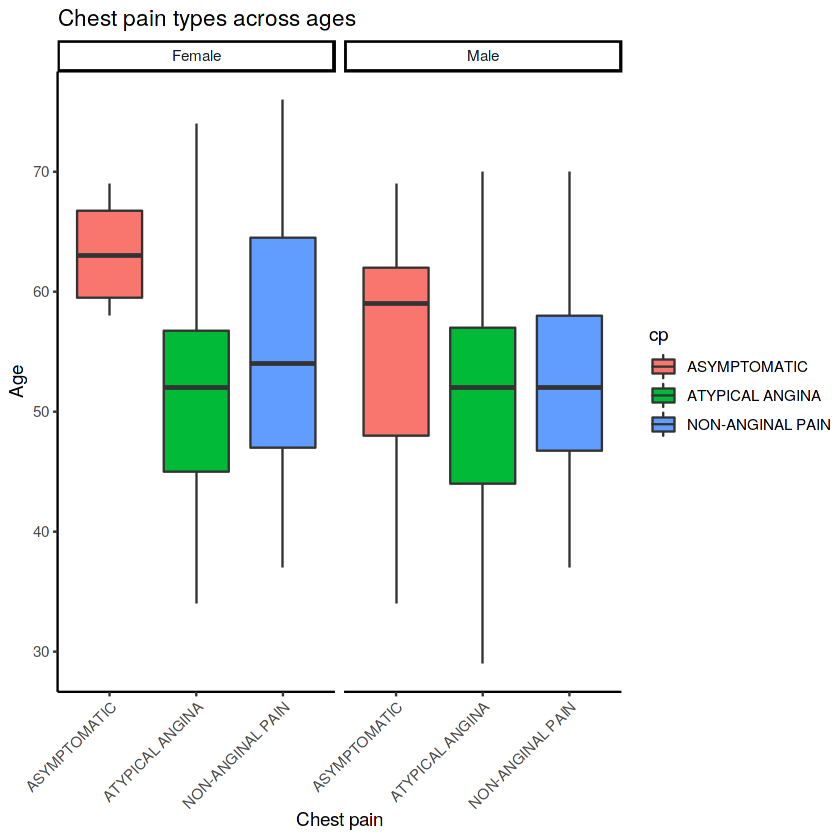

In [15]:
heart_clean %>% 
  filter(cp != "None") %>% 
  ggplot(aes(cp, age, fill = cp )) +
  geom_boxplot() +
  theme_classic() +
  labs(title = "Chest pain types across ages",
       y = "Age",
       x = "Chest pain") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_grid(~sex)

The older you are the more server the chest pain.

**Fasting blood sugar  across ages**

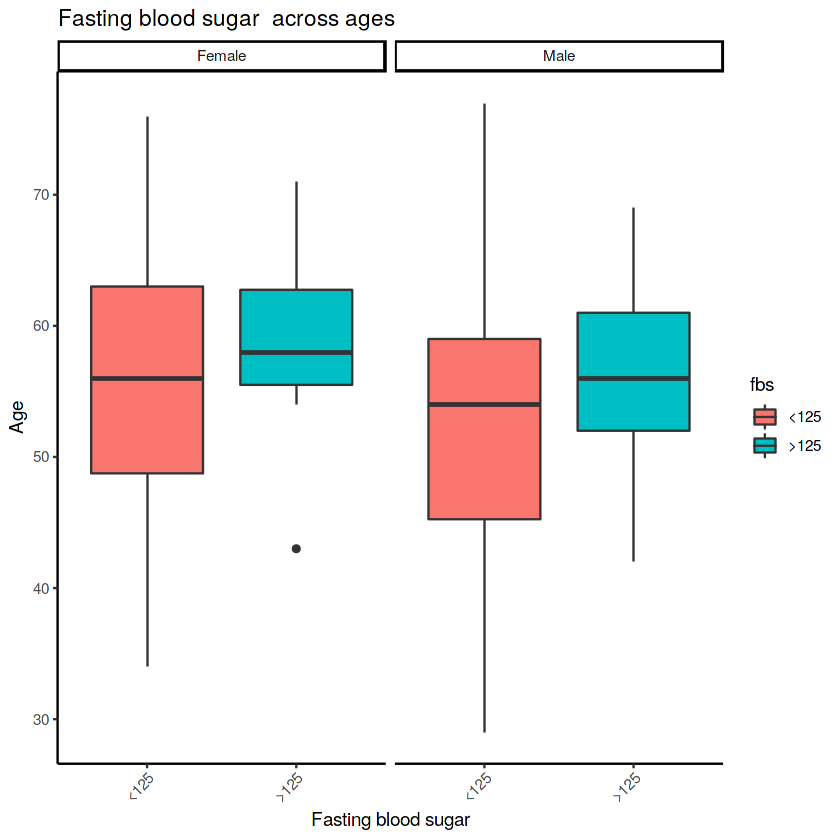

In [16]:
heart_clean %>% 
  ggplot(aes(fbs, age, fill = fbs )) +
  geom_boxplot() +
  theme_classic() +
  labs(title = "Fasting blood sugar  across ages",
       y = "Age",
       x = "Fasting blood sugar") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_grid(~sex)

Fasting blood sugar levels are higher as you age.


**Distribution of heart disease across chest pains**

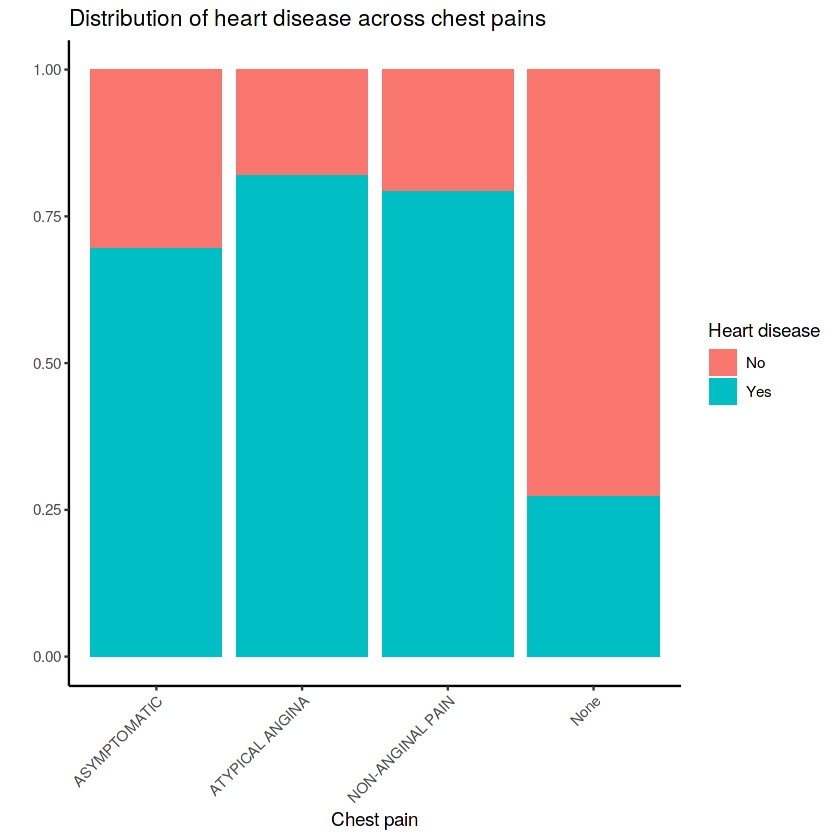

In [17]:
heart_clean %>% 
  ggplot(aes(cp, fill = target)) +
  geom_bar(position = "fill") +
  theme_classic() +
  labs(x = "Chest pain",
       y = "",
       title = "Distribution of heart disease across chest pains",
       fill = "Heart disease") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

**Distribution of heart disease across resting electrocardiographic**

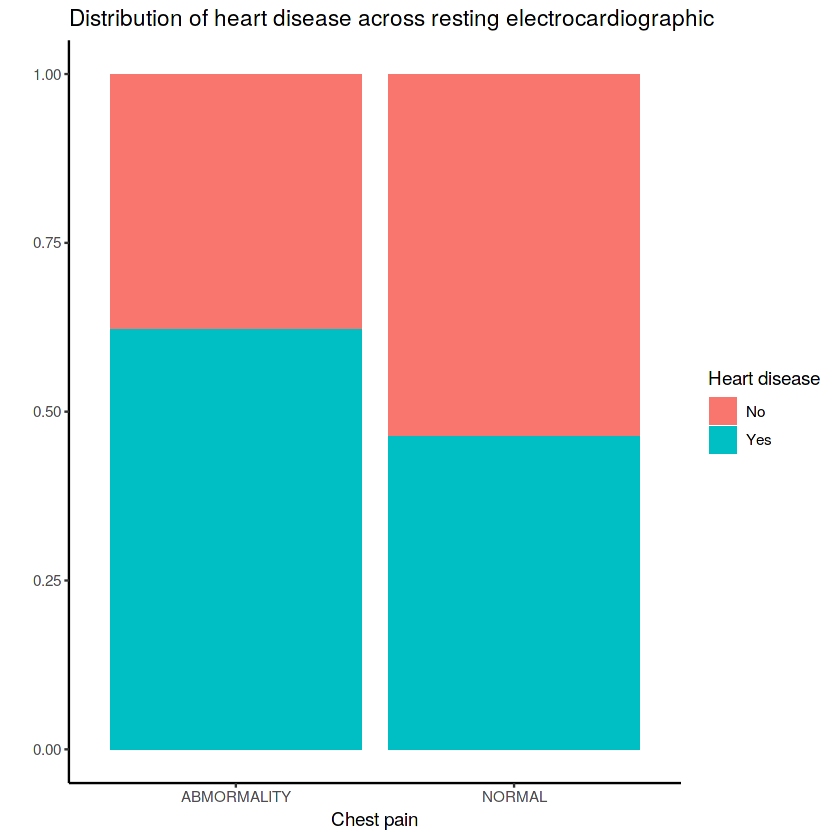

In [18]:
heart_clean %>% 
  ggplot(aes(restecg, fill = target)) +
  geom_bar(position = "fill") +
  theme_classic() +
  labs(x = "Chest pain",
       y = "",
       title = "Distribution of heart disease across resting electrocardiographic",
       fill = "Heart disease")

**Distribution of heart disease across the slope of the peak exercise ST segment**

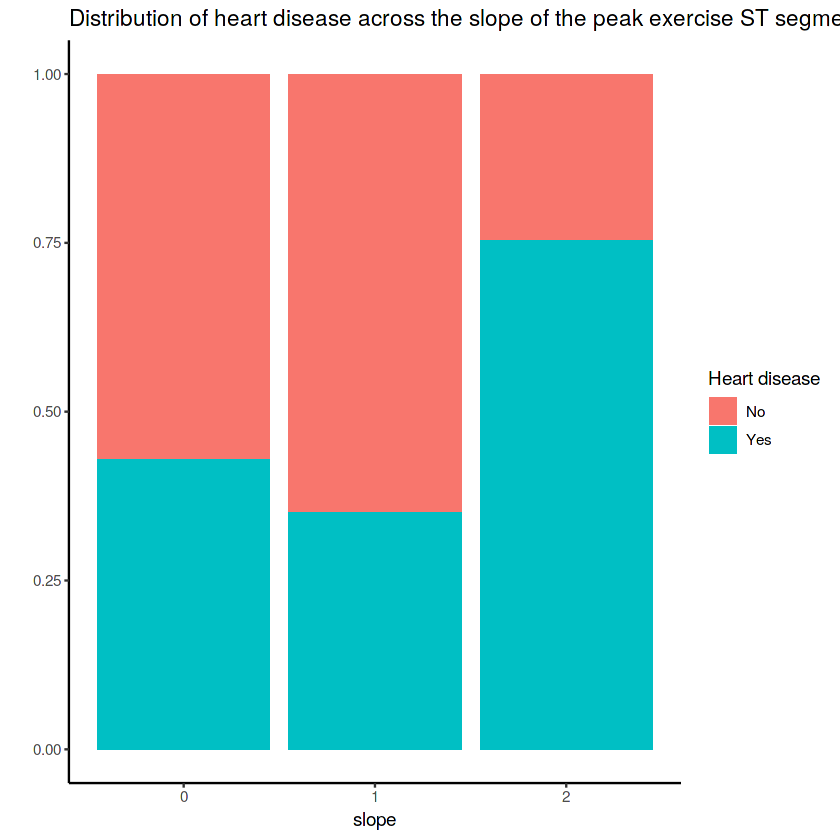

In [19]:
heart_clean %>% 
  ggplot(aes(slope, fill = target)) +
  geom_bar(position = "fill") +
  theme_classic() +
  labs(x = "slope",
       y = "",
       title = "Distribution of heart disease across the slope of the peak exercise ST segment",
       fill = "Heart disease")


**Distribution of heart disease across  number of major vessels**

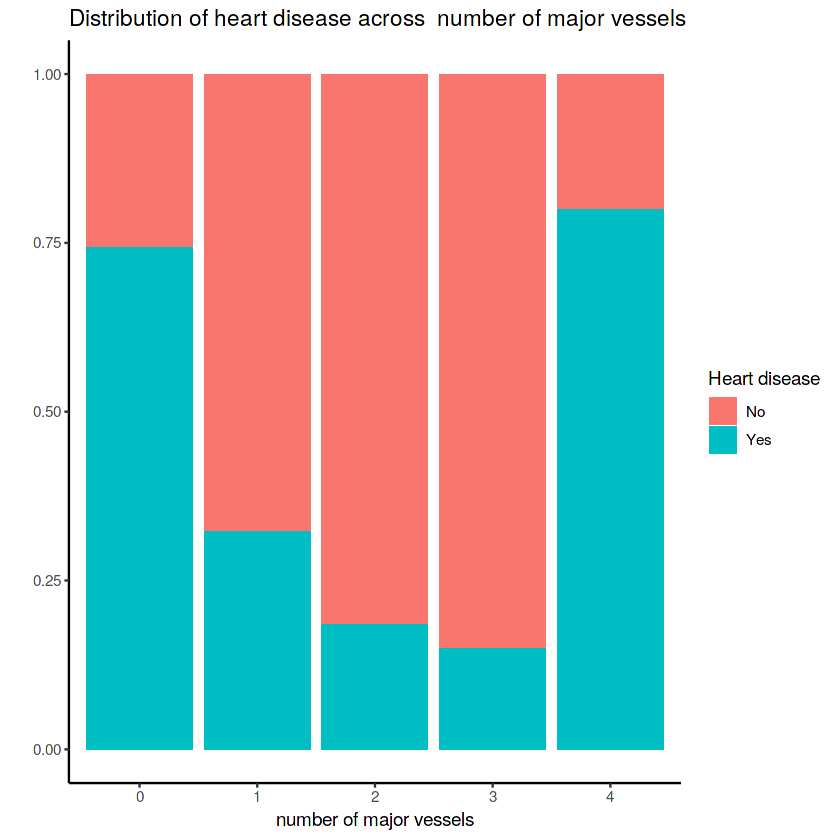

In [20]:
heart_clean %>% 
  ggplot(aes(ca, fill = target)) +
  geom_bar(position = "fill") +
  theme_classic() +
  labs(x = "number of major vessels",
       y = "",
       title = "Distribution of heart disease across  number of major vessels",
       fill = "Heart disease")

**Distribution of heart disease across thal**

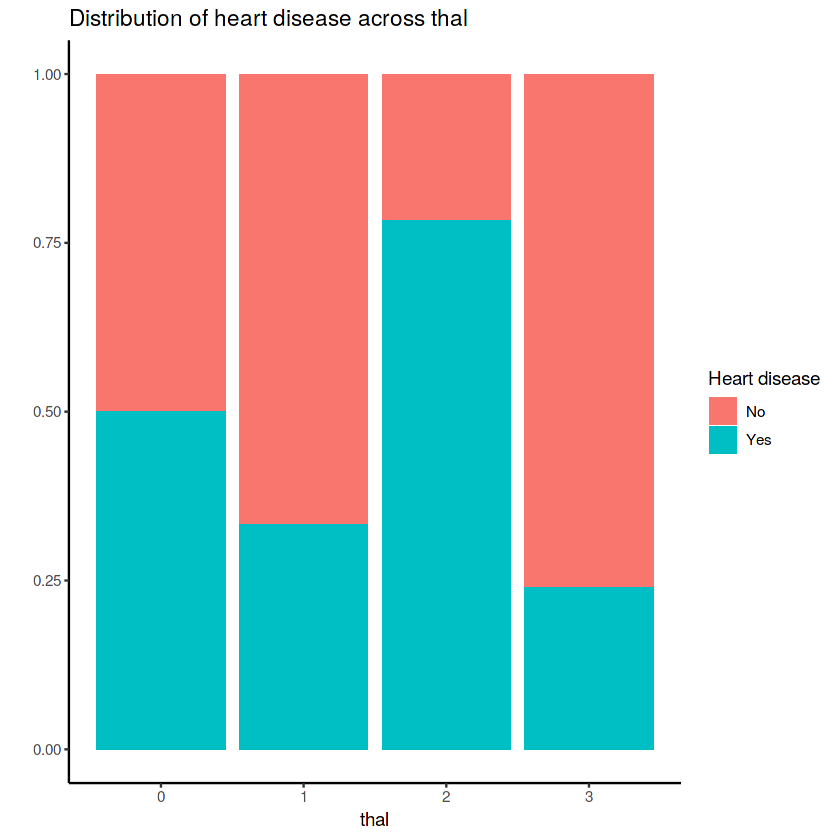

In [21]:
heart_clean %>% 
  ggplot(aes(thal, fill = target)) +
  geom_bar(position = "fill") +
  theme_classic() +
  labs(x = "thal",
       y = "",
       title = "Distribution of heart disease across thal",
       fill = "Heart disease")

**CORRELATION**

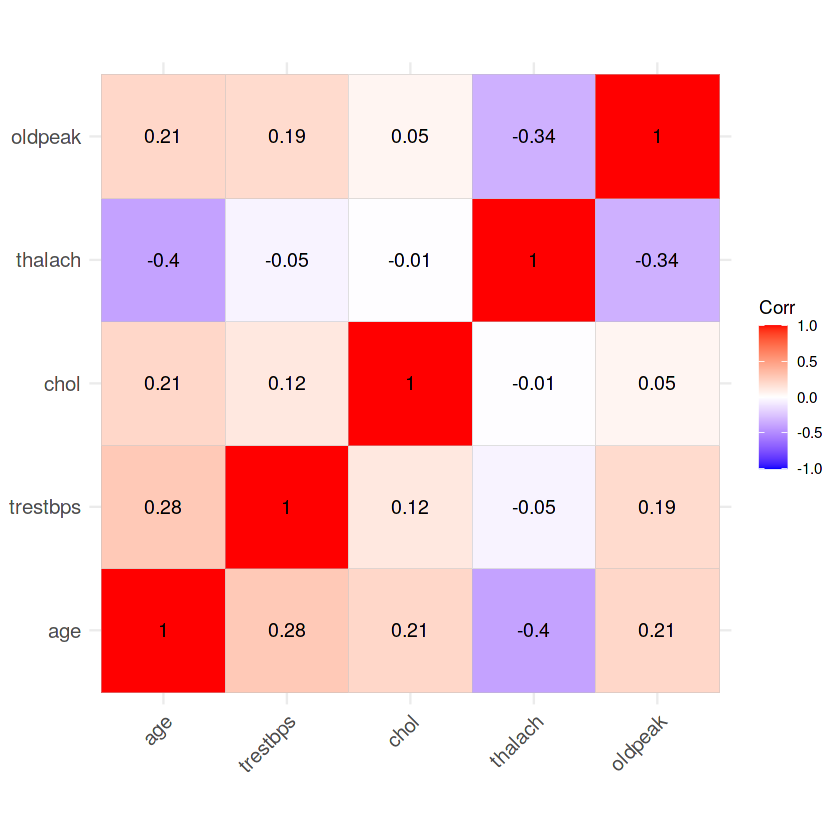

In [22]:
cor_heart <- cor(heart[, c(1,4,5,8,10)])

col <- colorRampPalette(c("orange", "green", "blue"))(20)

ggcorrplot(cor_heart, lab = T)

There is no high correlation between the other variables so we don't have to worry about multicollinearity.

# MODEL BUILDING

In [23]:
#split the data into train and test 
set.seed(123)
heart_split <- initial_split(heart_clean , strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

#create folds for resampling
set.seed(345)
heart_folds <- vfold_cv(heart_train)


I will create a recipe that will do the pre-processing for us.

In [24]:
library(themis)

#The recipe helps us with class imbalances
heart_rec <- recipe(target ~ ., data = heart_train) %>% 
  step_dummy(all_nominal(), -target) %>% 
  step_smote(target)

#create a workflow
heart_wf <- workflow() %>% 
  add_recipe(heart_rec)

heart_wf

Registered S3 methods overwritten by 'themis':
  method                  from   
  bake.step_downsample    recipes
  bake.step_upsample      recipes
  prep.step_downsample    recipes
  prep.step_upsample      recipes
  tidy.step_downsample    recipes
  tidy.step_upsample      recipes
  tunable.step_downsample recipes
  tunable.step_upsample   recipes


Attaching package: ‘themis’


The following objects are masked from ‘package:recipes’:

    step_downsample, step_upsample




══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: None

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_dummy()
● step_smote()

Build the models.

We are training a linear regression and a random forest model.

In [25]:
#linear regression
glm_spec <- logistic_reg() %>% 
  set_engine("glm")

#random forest
rf_spec <- rand_forest(trees = 1000) %>% 
  set_engine("ranger") %>% 
  set_mode("classification")

Training the linear regression model.

In [26]:
doParallel::registerDoParallel()

set.seed(567)

glm_rs <- heart_wf %>% 
  add_model(glm_spec) %>% 
  fit_resamples(
    resamples = heart_folds,
    metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),
    control = control_resamples(save_pred = TRUE)
  )




Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘vctrs’


The following object is masked from ‘package:dplyr’:

    data_frame


The following object is masked from ‘package:tibble’:

    data_frame




Training the random forest model.

In [27]:
doParallel::registerDoParallel()

set.seed(678)

rf_rs <- heart_wf %>% 
  add_model(rf_spec) %>% 
  fit_resamples(
    resamples = heart_folds,
    metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),
    control = control_resamples(save_pred = TRUE)
  )

# EVALUATE THE MODELS

In [28]:
#Collect the metrics
collect_metrics(glm_rs)
collect_metrics(rf_rs)

#confusion matrix
glm_rs %>% 
  conf_mat_resampled()

rf_rs %>% 
  conf_mat_resampled()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
accuracy,binary,0.8290514,10,0.02666357,Preprocessor1_Model1
roc_auc,binary,0.9040797,10,0.02178033,Preprocessor1_Model1
sens,binary,0.8266234,10,0.04040998,Preprocessor1_Model1
spec,binary,0.8199453,10,0.04445426,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
accuracy,binary,0.8247036,10,0.02037704,Preprocessor1_Model1
roc_auc,binary,0.8953723,10,0.02137025,Preprocessor1_Model1
sens,binary,0.8007565,10,0.03778520,Preprocessor1_Model1
spec,binary,0.8394245,10,0.03196666,Preprocessor1_Model1


Prediction,Truth,Freq
<fct>,<fct>,<dbl>
No,No,8.7
No,Yes,2.2
Yes,No,1.7
Yes,Yes,10.2


Prediction,Truth,Freq
<fct>,<fct>,<dbl>
No,No,8.4
No,Yes,2.0
Yes,No,2.0
Yes,Yes,10.4


The linear regression performed better.

We will use it for our finalprediction

In [29]:
#Tune model with best parameters
best_auc <- select_best(glm_rs, "roc_auc")

#create workflow for glm
glm_wf <- workflow() %>% 
  add_model(glm_spec) %>% 
  add_recipe(heart_rec)

final_glm <- finalize_workflow(glm_wf, best_auc)

final_results <- glm_wf %>% last_fit(heart_split)

collect_metrics(final_results)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<fct>
accuracy,binary,0.7733333,Preprocessor1_Model1
roc_auc,binary,0.8744620,Preprocessor1_Model1


Let us look at variable imporatnce graph.

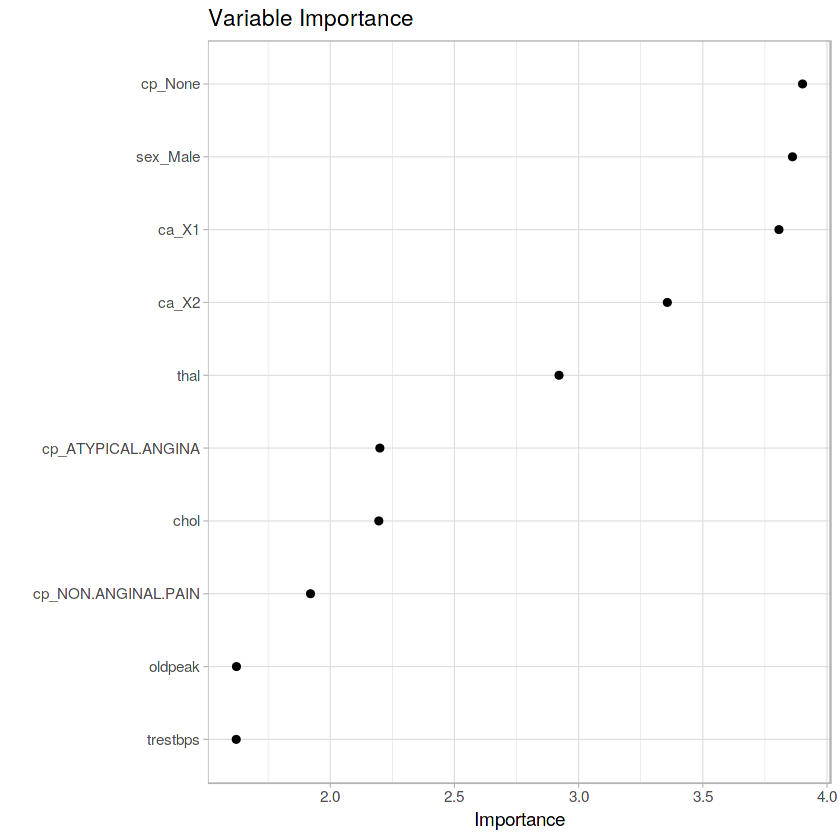

In [30]:
final_glm %>% 
  fit(data = heart_train) %>% 
  pull_workflow_fit() %>% 
  vip(geom = "point") +
  theme_light() +
  ggtitle("Variable Importance")